## 0. Téma projektu
Mojím projektom bolo vytvorenie predikcie ratingu čokolády, na základe jej podstatných vlastností.
Vybraný dataset obsahuje všetky podstatné vlastnosti a parametre, ktoré by sme o čokoláde mali vedieť.
Parametre a vlastnosti, ktoré tento dataset obsahuje:
- Výrobca čokolády
- Pôvod čokolády
- Referenčná hodnota spojená s okamihom, keď bola kontrola vložená do databázy. Čím je hodnota vyššia, tým je kakaový bôb čerstvejší.
- Dátum overenia
- Počet percent kakaa
- Sídlo výrobcu
- Hodnotenie
- Odroda kakaových bôbov
- Pôvod kakaových bôbov

Avšak nie všetky vlastnosti boli podstatné pre učenie neurónovej siete. Pre analýzu a neurónovú sieť sme museli niektoré stĺpce upraviť. 

## 1. Import knižníc, ktoré sme používali pre prácu s datasetom

In [17]:
#numpy je knižnica pre matice a matematické funkcie
#pre jednoduhší prístup ku knižnici jej priradíme alias np
import numpy as np

#pandas je knižnica pre dátové štruktúry a obsahuje pomôcky pre dátovú analýzu
#pre jednoduhší prístup ku knižnici jej priradíme alias pd
import pandas as pd

#matplotlib a seaborn je knižnica pre vykreslovanie grafov
#pyplot je súčasť knižnice matplotlib, ktorá pomáha generovať jednoduché grafy
#pre jednoduhší prístup ku knižnici jej priradíme alias plt a sns
import matplotlib.pyplot as plt
import seaborn as sns

#MinMaxScaler upravuje mierku a prekladá každú vlastnosť individuálne tak, 
#aby bola v danom rozmedzí na cvičnej množine, napr. medzi nulou a jednou.
from sklearn.preprocessing import MinMaxScaler

#Train test split rozdelí polia alebo matice na náhodné trénovacie a testovacie podmnožiny z datasetu
from sklearn.model_selection import train_test_split

#TensorFlow je bezplatná knižnica pre strojové učenie. 
#Môže sa použiť na rôzne úlohy, ale zameriava sa hlavne na výcvik a odvodenie hlbokých neurónových sietí
#!pip install --upgrade tensorflow
import tensorflow as tf

## 2. Import a analýza datasetu

In [18]:
#precitanie suboru, v ktorom sú parametre výrobcov čokolád a samotnej čokolády

data = pd.read_csv("flavors_of_cacao.csv") 
data

#my sa budeme snažiť o predikciu columnu Rating, resp. či bude model schopný predikovať hodnotenie čokolády na základe jej parametrov

,Company \r\n(Maker-if known),Specific Bean Origin\r\nor Bar Name,REF,Review\r\nDate,Cocoa\r\nPercent,Company\r\nLocation,Rating,Bean\r\nType,Broad Bean\r\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


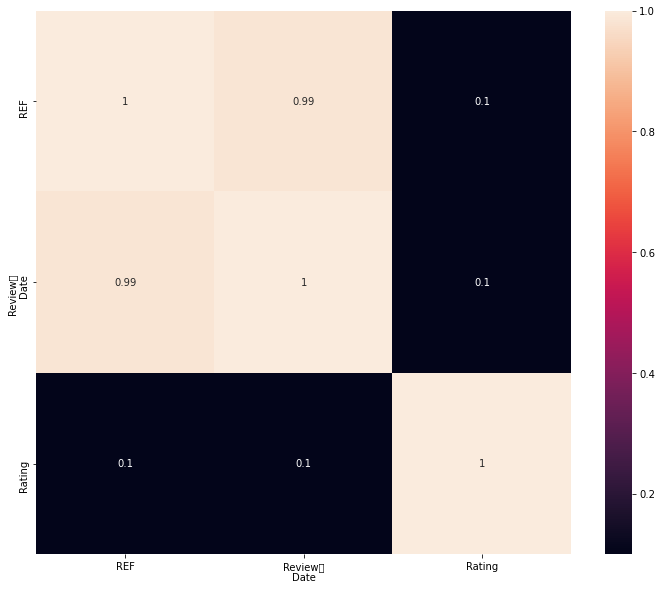

In [19]:
#Aby sme zistili, aké vzťahy majú medzi sebou všetky číselné stĺpce, vytvoríme si graf korelácie

plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()

#review date and referency (REF) majú skoro hodnotu 1, pretože sú skoro rovnaká feature,
#avšak neexistuje skoro žiadna korelácia na rating.

## 3. Úprava datasetu na ďalšiu prácu

In [20]:
#Review date a REF nám nebudú poskytovať dôležité informácie pri trénovaní a učení siete, preto ich z datasetu môžeme vymazať

data.drop(['REF', 'Review\r\nDate'], axis=1, inplace=True)
data

,Company \r\n(Maker-if known),Specific Bean Origin\r\nor Bar Name,Cocoa\r\nPercent,Company\r\nLocation,Rating,Bean\r\nType,Broad Bean\r\nOrigin
0,A. Morin,Agua Grande,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,70%,France,2.75,,Togo
2,A. Morin,Atsane,70%,France,3.00,,Togo
3,A. Morin,Akata,70%,France,3.50,,Togo
4,A. Morin,Quilla,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...
1790,Zotter,Peru,70%,Austria,3.75,,Peru
1791,Zotter,Congo,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,62%,Austria,3.25,,India


In [21]:
#Aby sme sa vyvarovali zlým výsledkom, musíme upraviť stĺpce, ktoré obsahujú null, alebo sú prázdne riadky.

data.isnull().sum()

#Zistili sme, že nežiadúce riadky obsahujú Odroda bôbu a Pôvod bôbov

Company \r\n(Maker-if known)           0
Specific Bean Origin\r\nor Bar Name    0
Cocoa\r\nPercent                       0
Company\r\nLocation                    0
Rating                                 0
Bean\r\nType                           1
Broad Bean\r\nOrigin                   1
dtype: int64

In [22]:
#V prípade, ak by náš dataset mal málo záznamov, museli by sme vymyslieť, ako tieto prázdne hodnoty nahradiť, 
#podľa ostatných riadkov, avšak keďže náš dataset má okolo 18000 riadkov, môžeme si dovoliť tieto riadky odstrániť

data = data.dropna(axis=0)

#Pre hlbšie porozumenie dátam si zistíme, aký typ premennej sú naše stĺpce v datasete

data.dtypes 

Company \r\n(Maker-if known)            object
Specific Bean Origin\r\nor Bar Name     object
Cocoa\r\nPercent                        object
Company\r\nLocation                     object
Rating                                 float64
Bean\r\nType                            object
Broad Bean\r\nOrigin                    object
dtype: object

In [23]:
#Ako sme si už mohli všimnúť pri prvom zobrazení nášho datasetu, je vidieť, že má veľmi komplikované názvy stĺpcov
#Pre lepšiu manipuláciu si stĺpce premenujeme

data.columns = ['Company', 'SpecificOrigin', 'CocoaPercent', 'Location', 'Rating', 'BeanType', 'BroadOrigin'] 
data

,Company,SpecificOrigin,CocoaPercent,Location,Rating,BeanType,BroadOrigin
0,A. Morin,Agua Grande,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,70%,France,2.75,,Togo
2,A. Morin,Atsane,70%,France,3.00,,Togo
3,A. Morin,Akata,70%,France,3.50,,Togo
4,A. Morin,Quilla,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...
1790,Zotter,Peru,70%,Austria,3.75,,Peru
1791,Zotter,Congo,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,62%,Austria,3.25,,India


In [24]:
#Ako ďalšiu zo zmien datasetu si odstránime znak percenta zo stĺpca CocoaPercent
#Pre tento krok si vytvoríme metódu, ktorá nám prejde všetky riadky v zadanom stĺpci a tento znak odstráni
def removePercents(data):
    return data.apply(lambda x: float(x.strip('%')) / 100)
data['CocoaPercent'] = removePercents(data['CocoaPercent'])

data

<ipython-input-24-cc6e09e25de3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CocoaPercent'] = removePercents(data['CocoaPercent'])


,Company,SpecificOrigin,CocoaPercent,Location,Rating,BeanType,BroadOrigin
0,A. Morin,Agua Grande,0.63,France,3.75,,Sao Tome
1,A. Morin,Kpime,0.70,France,2.75,,Togo
2,A. Morin,Atsane,0.70,France,3.00,,Togo
3,A. Morin,Akata,0.70,France,3.50,,Togo
4,A. Morin,Quilla,0.70,France,3.50,,Peru
...,...,...,...,...,...,...,...
1790,Zotter,Peru,0.70,Austria,3.75,,Peru
1791,Zotter,Congo,0.65,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,0.65,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,0.62,Austria,3.25,,India


In [10]:
#dataset bude mať vysokú kardinalitu after we perform one hot encoding, pretože ak sa pozrieme napr na Specific Origin
#koľko ich je: 
len(data['SpecificOrigin'].unique())
# s 1038 specific origins pri jednom hot encoding dosiahneme 1038 nových features k datasetu, čo by mohlo byť ok, ale 
#ideme robiť high variance model to account for that, takže neurónové siete budú pre tento prípad najlepším riešením

1038

In [11]:
#ideme konvertovať všetky categorical features in one hot encoded forms
#ako prvé si spravíme list, v ktorom su categorical columns, čiže všetky okrem percent a rating
categorical_features = ['Company', 'SpecificOrigin', 'Location', 'BeanType', 'BroadOrigin']

pd.get_dummies(data['Company'])
 #naplní nám dáta, zo všetkych unique values urobí columns and the value of each example then becomes a one 
 #in the corresponding columns and the zero in the others. So this is calls one-hot, because there is one hot
 #and others is zero
      



,A. Morin,AMMA,Acalli,Adi,Aequare (Gianduja),Ah Cacao,Akesson's (Pralus),Alain Ducasse,Alexandre,Altus aka Cao Artisan,...,Xocolla,Zak's,Zart Pralinen,Zokoko,Zotter,hello cocoa,hexx,iQ Chocolate,organicfair,twenty-four blackbirds
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
#napíšeme si jednu hot encoded funkciu pre celý dataset, ktorá nám dá list of columns
def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column]) #naplníme ju datasetom a stĺpcami, ktoré chcem one hot encodnuť - get dummies matrix for each column
        data = pd.concat([data, dummies], axis=1) #spravíme concat s dummies datas a original datas
        data.drop(column, axis=1, inplace=True)
    return data 

In [13]:
data = onehot_encode(data, categorical_features)

In [15]:
y = data['Rating']
X = data.drop('Rating', axis=1)
X

,CocoaPercent,A. Morin,AMMA,Acalli,Adi,Aequare (Gianduja),Ah Cacao,Akesson's (Pralus),Alain Ducasse,Alexandre,...,Venezuela,"Venezuela, Carribean","Venezuela, Dom. Rep.","Venezuela, Ghana","Venezuela, Java","Venezuela, Trinidad",Venezuela/ Ghana,Vietnam,West Africa,
0,0.63,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0.70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,0.65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,0.65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793,0.62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#nasledne po konvertovaní categoricall variables a naplnenie tabuľky dummy textom, možeme začať s neuronovými sieťami,
#použijeme tensorflow
#this is also a regression problem since we are trying to predict a value between zero and five as the rating 
# 1. split the data between y and x

y = data['Rating']
X = data.drop('Rating', axis=1)

X

#tabulka predstavuje všetky dáta okrem hodnôt Rating, takže we are going to scale it down

,CocoaPercent,A. Morin,AMMA,Acalli,Adi,Aequare (Gianduja),Ah Cacao,Akesson's (Pralus),Alain Ducasse,Alexandre,...,Venezuela,"Venezuela, Carribean","Venezuela, Dom. Rep.","Venezuela, Ghana","Venezuela, Java","Venezuela, Trinidad",Venezuela/ Ghana,Vietnam,West Africa,
0,0.63,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.70,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0.70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,0.65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,0.65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793,0.62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#this make it fit - we fit the scalar to our X, it will find min and max for each column
#and then we will transform X by squashing the min and max down to be between zero and one. 
#so every feature will be between zero and one

X


,CocoaPercent,A. Morin,AMMA,Acalli,Adi,Aequare (Gianduja),Ah Cacao,Akesson's (Pralus),Alain Ducasse,Alexandre,...,Venezuela,"Venezuela, Carribean","Venezuela, Dom. Rep.","Venezuela, Ghana","Venezuela, Java","Venezuela, Trinidad",Venezuela/ Ghana,Vietnam,West Africa,
0,0.362069,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.482759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.482759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.482759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.482759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,0.482759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1789,0.396552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1790,0.396552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1791,0.344828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#TRAINING THE MODEL

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) #train size on 80%

#we add functional api for keras model - we will specify the inputs layer

inputs = tf.keras.Input(shape=(1655,)) #the shape is going to be a vector of 1655 colums features
x = tf.keras.layers.Dense(16, activation='relu')(inputs) #hidden layers, both will be fully connected dense layers, 16 nodes for each
x = tf.keras.layers.Dense(16, activation='relu')(x) #there will pased x, on upper line the input will be pased
outputs = tf.keras.layers.Dense(1)(x) #there will be return only one value because its regresion and we will not give it an activation function
                                      #because we want only the final predicted value

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [19]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(
    optimizer=optimizer,
    loss='mse'
)
model.summary()

#4 layers, 1 input, 2 hidden layers and 1 output. It started with 1655 features and ends it with 1 value as prediction

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1655)]            0         
_________________________________________________________________
dense (Dense)                (None, 16)                26496     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 26,785
Trainable params: 26,785
Non-trainable params: 0
_________________________________________________________________


In [20]:
#train the model
#we will specify the epoch says 50 and we will store our model's performance in the history variable

epochs = 10
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2, #20% 
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/10
36/36 [==============================] - 1s 25ms/step - loss: 8.8250 - val_loss: 5.0103
Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 3.6915 - val_loss: 0.9280
Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.5782 - val_loss: 0.2923
Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2493 - val_loss: 0.2480
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.2139 - val_loss: 0.2374
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.1797 - val_loss: 0.2324
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.1558 - val_loss: 0.2350
Epoch 8/10
36/36 [==============================] - 0s 2ms/step - loss: 0.1306 - val_loss: 0.2253
Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 0.1012 - val_loss: 0.2274
Epoch 10/10
36/36 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.2243


In [21]:
history.history #dictionary of metrics that we have. In this case, the only metrics will be loss and validation loss 
                #because we didnt specify any more. This is the loss at each epoch of training,
                #so we can see how its goes down naturally

{'loss': [7.593544006347656,
  2.692336320877075,
  0.4332706034183502,
  0.2555602788925171,
  0.2052716463804245,
  0.17340175807476044,
  0.1495441496372223,
  0.13044583797454834,
  0.11474182456731796,
  0.10304451733827591],
 'val_loss': [5.0103020668029785,
  0.9280439019203186,
  0.29233232140541077,
  0.24798737466335297,
  0.23739223182201385,
  0.2323789745569229,
  0.23501752316951752,
  0.2252744883298874,
  0.22735781967639923,
  0.2242990881204605]}

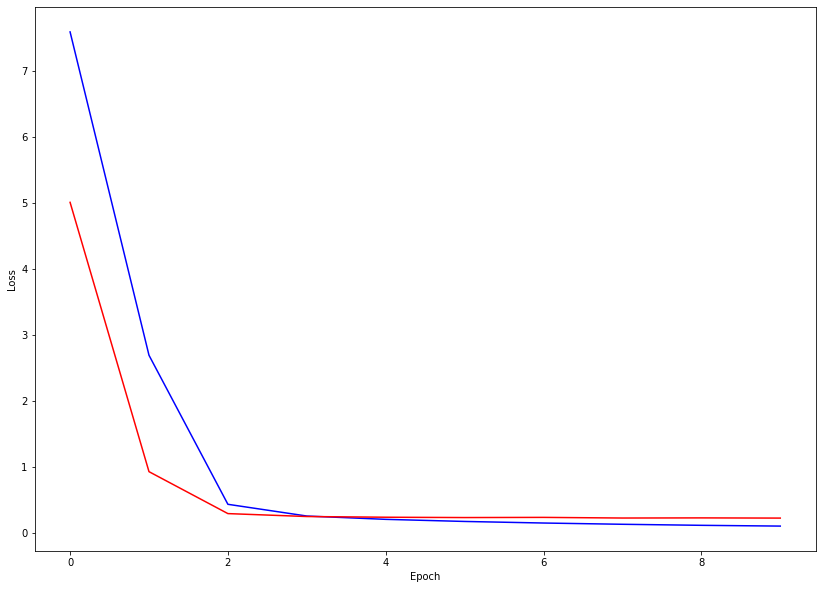

In [22]:
#we plotting two lines - the training loss and the validation loss
#the x will have the number of epochs, the y will have the number of validation loss
plt.figure(figsize=(14, 10))

plt.plot(range(epochs), history.history['loss'], color='b')
plt.plot(range(epochs), history.history['val_loss'], color='r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [23]:
np.argmin(history.history['val_loss']) #this will find a epoch that gives the lowest validation loss
#its 7, so that number is the best model performance

9

In [24]:
# finally, we will evaluate our model on the test set. Also, we get the lowest squared error

model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 636us/step - loss: 0.2343


0.23428629338741302